In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [112]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
dataset_path = './datasets/shrimp/20190425__fried_shrimp_line_reduced/'
images_path = glob.glob(os.path.join(dataset_path, '*.png'))

In [87]:
def load_img(path, gray=False):
    """
    OpenCVを用いて画像を読み込む関数．
    
    Parameters
    ----------
    path : str
        画像へのパス
    gray : True or False
        グレー画像として読み込むかの設定
    """
    if gray:
        img = cv2.imread(path, 0)  # IMREAD_GRAYSCALE
    else:
        img = cv2.imread(path, 1)  # IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 色空間の変換
    
    return img

## 今回のROI(白用紙の部分)について
画像全体のサイズ…600x800

Region of Interesting(矩形の左上と右下の点座標)

1701~1781まで…(270, 240), (580, 670)あたり

1782~1794まで…(250, 240), (560, 670)あたり

RoIサイズ…310x330

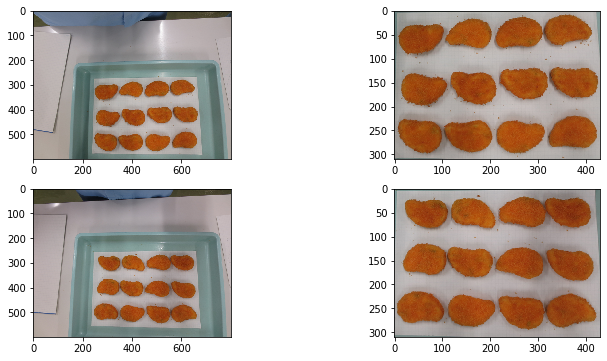

In [88]:
img_01_to_81 = load_img(images_path[0])
RoI_01_to_81 = img_01_to_81[270:580, 240:670, :]
img_rest = load_img(images_path[80])
RoI_rest = img_rest[250:560, 240:670, :]

plt.figure(figsize=(12, 6))
plt.subplot(221); plt.imshow(img_01_to_81)
plt.subplot(222); plt.imshow(RoI_01_to_81)
plt.subplot(223); plt.imshow(img_rest)
plt.subplot(224); plt.imshow(RoI_rest)
plt.show()

## RoI部分の保存

In [53]:
# 保存先ディレクトリがなければ作成
save_dir = './datasets/train/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [89]:
for i, path in enumerate(images_path):
    img = load_img(path)
    if i < 80:
        RoI = img[270:580, 240:670, :]          # RoI，トレー内の白紙の部分
    else:
        RoI = img[250:560, 240:670, :]
    RoI = cv2.cvtColor(RoI, cv2.COLOR_RGB2BGR)  # opencvの関数で保存するため，再変換
        
    file_name = path[-12:]                      # ファイル名(.pngの部分)
    save_path = os.path.join(save_dir, 'train_' + file_name)
    cv2.imwrite(save_path, RoI)

## マスク画像の作成

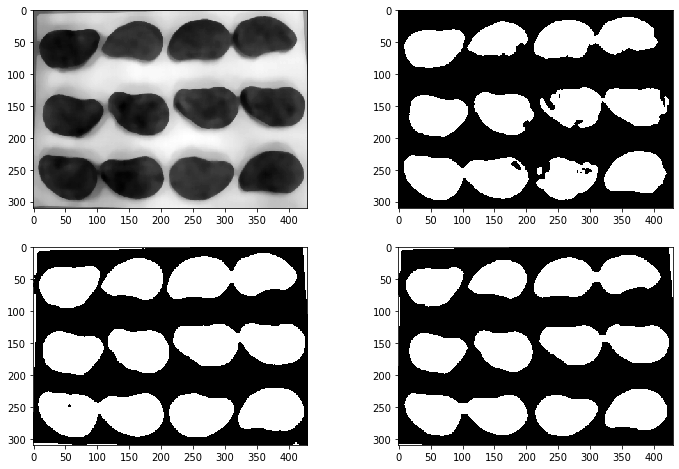

In [153]:
img = load_img(images_path[0], gray=True)  # 57とかヤバい
RoI = img[270:580, 240:670]

RoI = cv2.medianBlur(RoI, 11)
ret, thresh = cv2.threshold(RoI, 102, 255, cv2.THRESH_BINARY)
ada_thresh = cv2.adaptiveThreshold(RoI, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 99, 0)

# 白黒反転
thresh = ~thresh
ada_thresh = ~ada_thresh

# クロージング(内部の黒点除去)してから収縮して結合を切る
kernel_closing = np.ones((5, 5), np.uint8)
kernel_erosion = np.ones((5, 5), np.uint8)
ada_thresh_closing = cv2.morphologyEx(ada_thresh, cv2.MORPH_CLOSE, kernel_closing)
ada_thresh_erosion = cv2.erode(ada_thresh_closing, kernel_erosion, iterations=1)

plt.figure(figsize=(12, 8))
plt.subplot(221); plt.imshow(RoI, cmap='gray')
plt.subplot(222); plt.imshow(thresh, cmap='gray')
plt.subplot(223); plt.imshow(ada_thresh, cmap='gray')
plt.subplot(224); plt.imshow(ada_thresh_erosion, cmap='gray')
plt.show()